In [205]:
import sys
sys.path.append("..")
import ProbabilisticParcellation.util as ut
import ProbabilisticParcellation.hierarchical_clustering as cl
import ProbabilisticParcellation.similarity_colormap as cm
import ProbabilisticParcellation.functional_profiles as fp
from ProbabilisticParcellation.scripts.atlas_paper.ridge_reg import ridgeFit

from Functional_Fusion.dataset import *
import matplotlib.pyplot as plt
import string
import PcmPy as pcm
from copy import deepcopy
import torch as pt



base_dir = '/Volumes/diedrichsen_data$/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/srv/diedrichsen/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/Users/callithrix/Documents/Projects/Functional_Fusion/'
if not Path(base_dir).exists():
    raise (NameError('Could not find base_dir'))
    

## Load profile data and model

In [325]:
atlas = 'MNISymC2'

# load model
mname = f'/Models_03/NettekovenSym32_space-MNISymC2'
fileparts = mname.split('/')
split_mn = fileparts[-1].split('_')
# info, model = ut.load_batch_best(mname)


# load labels and cmap
lut_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/ProbabilisticParcellationModel/Atlases/'
_, cmap, labels = nt.read_lut(lut_dir +
                              f'{split_mn[0]}.lut')
labels=labels[1:]

# load profile
profile = pd.read_csv(
    f'{ut.model_dir}/Atlases/Profiles/{fileparts[-1].split("_")[0]}_profile_model.tsv', sep="\t"
)

In [326]:
# Reduce profile to only MDTB Tasks
profile = profile[profile.dataset == 'MDTB']
# Make condition into row index and drop everything other than parcel columns
profile = profile.set_index('condition')
profile = profile[labels]

# Make profile into matrix
profile_mat = profile[labels].to_numpy()

# Subtract the mean profile
profile_scaled = (profile_mat - np.mean(profile_mat, axis=0))


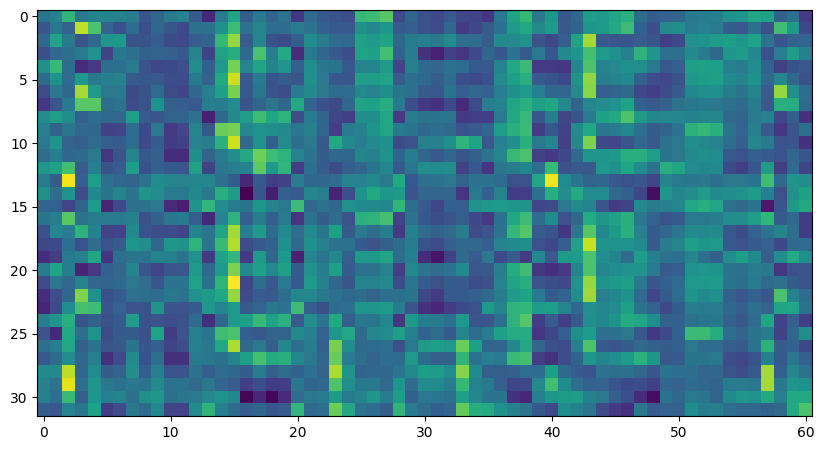

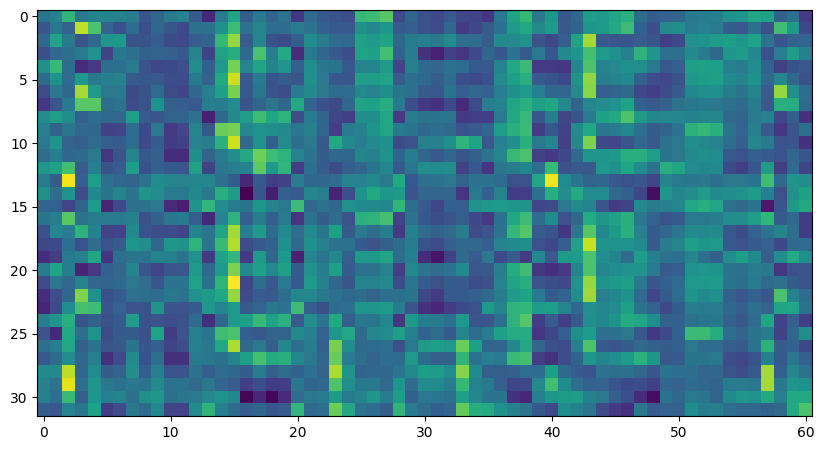

In [327]:
figsize = (10, 10)
# Show scaled profile
plt.figure(figsize=figsize)
plt.imshow(profile_scaled.T)

plt.figure(figsize=figsize)
plt.imshow(profile_mat.T)




### Load cognitive feature tags

In [328]:
# Load cognitive features
tags = pd.read_csv(
    f'{ut.model_dir}/Atlases/Profiles/tags/tags_final.tsv', sep="\t"
)
# Reduce tags to only MDTB Tasks
tags = tags[tags.dataset == 'MDTB']
# Make condition into index 
tags = tags.set_index('condition')

# Drop everything other than mdtb tags
tags_first_tag_column = tags.columns.tolist().index('left_hand_response_execution')
last_mdtb_tag = tags.columns.tolist().index('right_toe_response_execution')
tags = tags.iloc[:, tags_first_tag_column:last_mdtb_tag]

In [329]:
# Repeat the tags for each participant
# Loop through the entries of profile.condition and repeat the tags.condition row 
mdtb_new = [
    "VideoAct",
    "VisualSearchSmall",
    "VisualSearchLarge",
    "SpatialMedDiff",
    "rest",
]
mdtb_old = [
    "VideoActions",
    "VisualSearchEasy",
    "VisualSearchMed",
    "SpatialMapDiff",
    "Rest",
]
mdtb_new2old = dict(zip(mdtb_new, mdtb_old))


for i, cond in enumerate(profile.index):
    try:
        row = tags.iloc[tags.index.tolist().index(cond)]
    except:
        row = tags.iloc[tags.index.tolist().index(mdtb_new2old[cond])]
    if i == 0:
        tags_cond = row
    else:
        tags_cond = pd.concat([tags_cond, row], axis=1)

tags_mat = tags_cond.T.to_numpy()



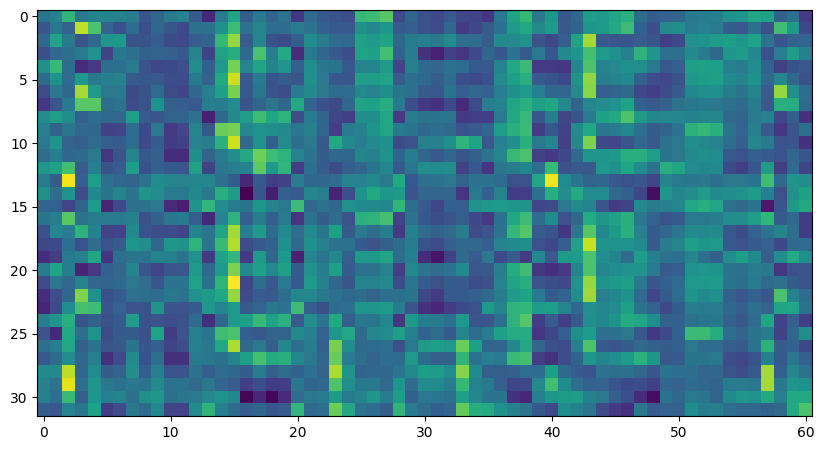

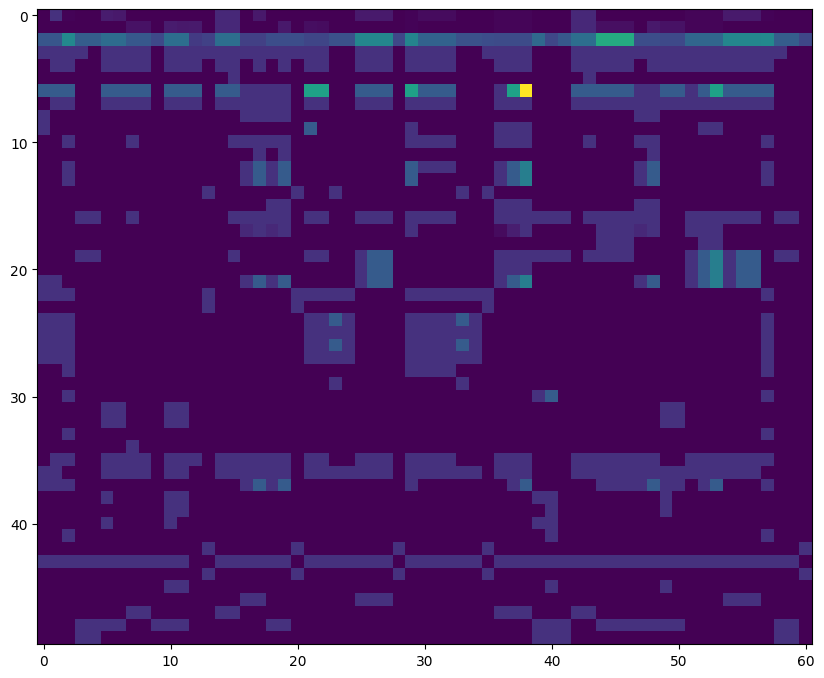

In [330]:
plt.figure(figsize=figsize)
plt.imshow(profile_mat.T)

plt.figure(figsize=figsize)
plt.imshow(tags_mat.T)


In [331]:
# Subtract mean from each column and divide by standard deviation of each column
tags_mat = (tags_mat - np.mean(tags_mat, axis=0)) / np.std(tags_mat, axis=0)

In [332]:
print(tags_mat[:, tags.columns == 'saccadic_eye_movement'])


[[-0.45166623]
 [-0.45166623]
 [ 1.40873392]
 [-0.18589478]
 [-0.18589478]
 [ 0.34564812]
 [ 0.34564812]
 [-0.36307575]
 [-0.36307575]
 [-0.89461865]
 [ 0.4342386 ]
 [ 0.4342386 ]
 [-1.33757107]
 [-1.11609486]
 [ 0.4342386 ]
 [ 0.4342386 ]
 [-1.1603901 ]
 [-1.1603901 ]
 [-0.71743768]
 [-0.71743768]
 [-0.71743768]
 [-0.98320913]
 [-0.98320913]
 [-0.6288472 ]
 [-0.6288472 ]
 [ 1.32014343]
 [ 1.32014343]
 [ 1.32014343]
 [-0.93891389]
 [ 1.27584819]
 [-0.00871382]
 [-0.00871382]
 [-0.00871382]
 [-0.6288472 ]
 [-0.6288472 ]
 [-0.71743768]
 [-0.80602817]
 [-0.80602817]
 [-0.80602817]
 [ 0.21276239]
 [-0.93891389]
 [-0.36307575]
 [ 0.4342386 ]
 [ 0.4342386 ]
 [ 2.78188641]
 [ 2.78188641]
 [ 2.78188641]
 [-0.71743768]
 [-0.71743768]
 [-0.89461865]
 [-0.89461865]
 [ 0.12417191]
 [ 0.12417191]
 [ 0.12417191]
 [ 1.32014343]
 [ 1.32014343]
 [ 1.32014343]
 [ 1.40873392]
 [-0.18589478]
 [-0.18589478]
 [-0.93891389]]


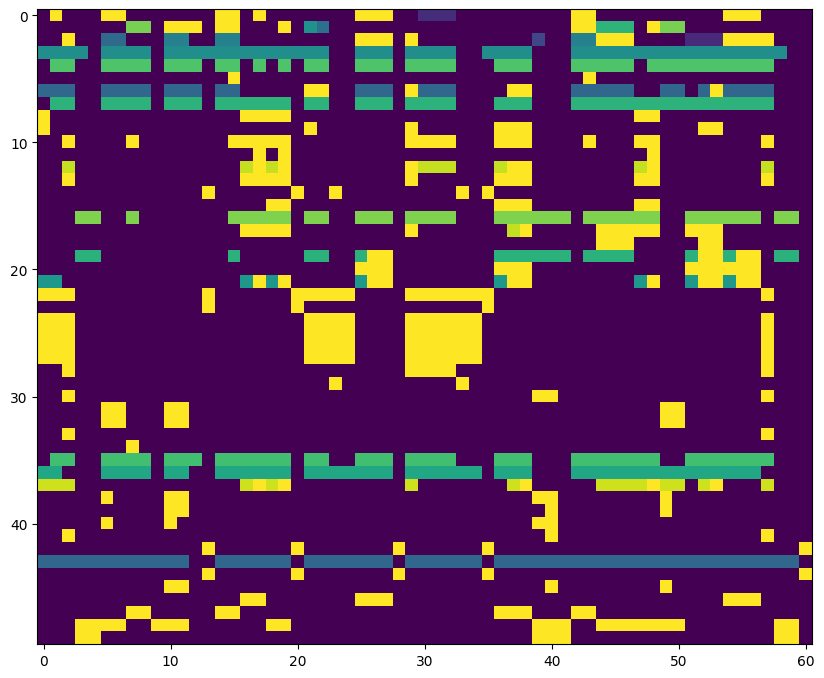

In [333]:
# Show features
plt.figure(figsize=(10, 10))
plt.imshow(tags_mat.T, vmin=0, vmax=1)


# Ridge Regression

In [334]:
R2, features = ridgeFit(profile_mat, tags_mat, fit_intercept=False, voxel_wise=False, alpha=1.0)
# Make dataframe with B values, profile.dataset, profile.condition, tags.columns[tags_first_tag_column:]
Features = pd.DataFrame(features.T, columns=tags.columns, index=labels)



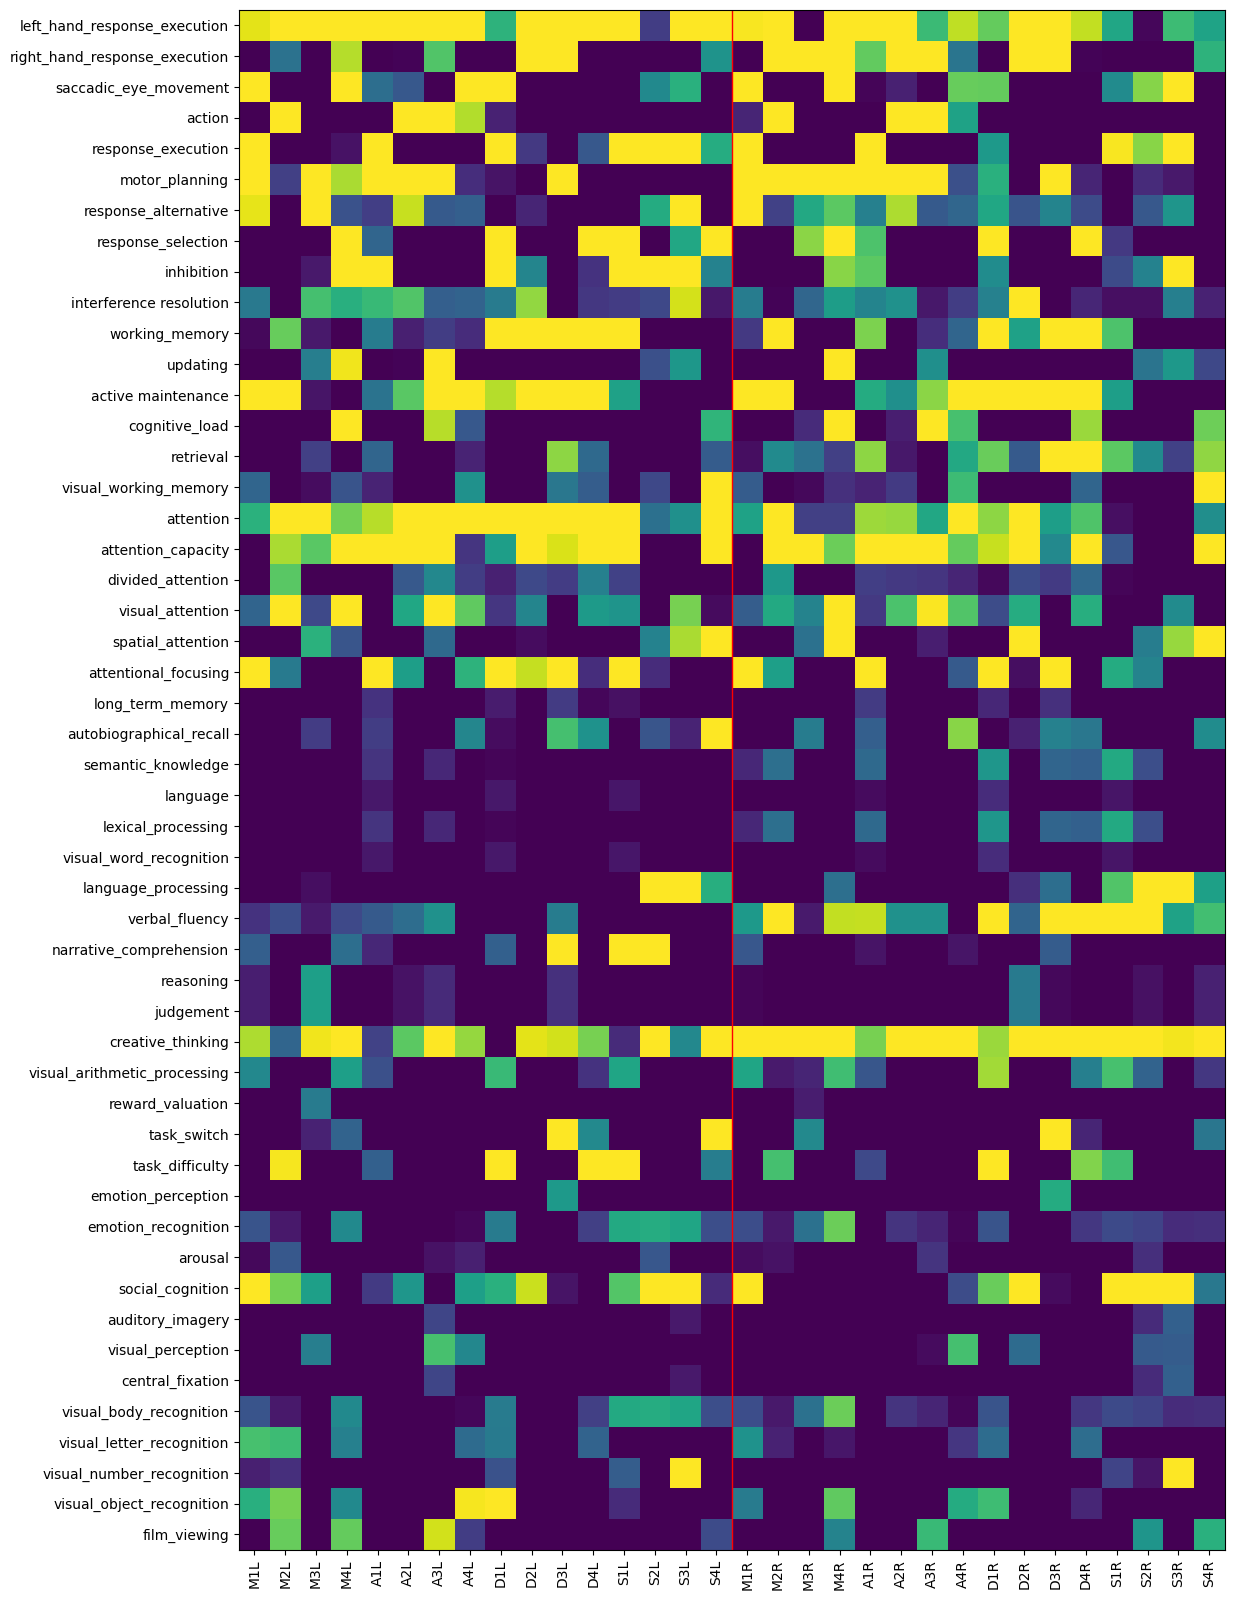

In [335]:
# Plot
plt.figure(figsize=(20, 20))
plt.imshow(features, vmin=0, vmax=0.03)
plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.yticks(np.arange(len(tags.columns)), tags.columns)
# Plot a medial line
plt.plot([len(labels)/2-0.5, len(labels)/2-0.5], [-0.5, len(tags.columns)-0.5], color='red', linewidth=1)


# Show highest features

In [336]:
def print_tags(profile, df, labels, region=None, n=5):

    for i, r in enumerate(labels):
        if (region is None) | (r == region):
            print(f'\nregion {r}')

            # Sort conditions by score
            scores = profile[:, i]
            zipped = zip(scores, df.columns)
            zipped = sorted(zipped, key=lambda x: x[0], reverse=True)
            scores, conds = zip(*zipped[:n])

            [print(f'{cond}: {score}')
             for score, cond in zip(scores, conds)]


In [342]:
for region in ['M1L', 'M1R']:
    print_tags(features, Features, labels, region=region, n=2)

for region in ['M2L', 'M2R']:
    print_tags(features, Features, labels, region=region, n=2)





region M1L
saccadic_eye_movement: 0.09541589725198539
attentional_focusing: 0.07247285802605266

region M1R
saccadic_eye_movement: 0.09561747427493864
attentional_focusing: 0.06698687858641261

region M2L
action: 0.11583462861499595
attention: 0.05547748149255924

region M2R
action: 0.09102201772418081
attention_capacity: 0.05649875180875026


In [343]:

for region in ['M3L', 'M3R']:
    print_tags(features, Features, labels, region=region, n=2)

for region in ['M4L', 'M4R']:
    print_tags(features, Features, labels, region=region, n=2)


region M3L
left_hand_response_execution: 0.12369823631777911
attention: 0.0405586965194114

region M3R
right_hand_response_execution: 0.0840219863168275
attention_capacity: 0.058048943338967304

region M4L
response_selection: 0.0732853612867613
left_hand_response_execution: 0.0675164881992393

region M4R
creative_thinking: 0.07918160277760887
response_selection: 0.07339170602004402
